# Week 1 Homework

In [1]:
import altair as alt
# to support rendering on github
alt.renderers.enable('mimetype')

import numpy as np
import pandas as pd
from scipy import stats

## Exercise 1

Suppose the globe tossing data (Chapter 2) had turned out to be 4 water and 11 land. Construct the posterior distribution, using grid approximation. Use the same flat prior as in the book.

In [2]:
# possible values for uknown parameter: water proportion
p_grid = np.linspace(0, 1, num=100)

prior = np.full_like(p_grid, 1)
prior = prior / prior.sum()

prob_data = stats.binom.pmf(k=4, n=4 + 11, p=p_grid)
prob_data = prob_data / prob_data.sum()

posterior = prior * prob_data
posterior = posterior / posterior.sum()

posterior_samples = np.random.choice(p_grid, p=posterior, size=5000)

In [3]:
# data source for plotting
source = pd.DataFrame(
    {
        "p_grid": p_grid,
        "prior": prior,
        "prob_data": prob_data,
        "posterior": posterior,
    }
)

# convert wide df to tall, keep `p_grid` column
source = source.melt("p_grid", value_name="density")
source.head()

,p_grid,variable,density
0,0.000000,prior,0.01
1,0.010101,prior,0.01
2,0.020202,prior,0.01
3,0.030303,prior,0.01
4,0.040404,prior,0.01


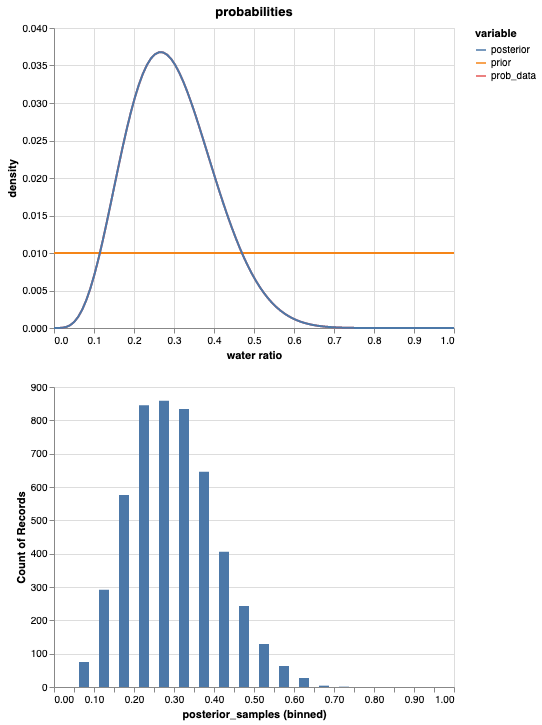

In [4]:
prob_lines = (
    alt.Chart(source, title="probabilities")
    .mark_line()
    .encode(
        alt.X("p_grid", title="water ratio"),
        y="density",
        color="variable",
    )
)

samples_source = pd.DataFrame({"posterior_samples": posterior_samples})
hist = (
    alt.Chart(samples_source)
    .mark_bar(size=10)
    .encode(
        x=alt.X("posterior_samples", bin=alt.BinParams(step=0.05, extent=[0, 1])),
        y="count()",
    )
)

alt.vconcat(prob_lines, hist)

In [5]:
posterior_mean = (p_grid * posterior).mean() * len(p_grid)
posterior_samples_mean = posterior_samples.mean()
print(
    f"posterior_mean={posterior_mean:.4f} posterior_samples_mean={posterior_samples_mean:.4f}"
)

posterior_mean=0.2941 posterior_samples_mean=0.2968


## Exercise 2

Now suppose the data are 4 water and 2 land. Compute the posterior again, but this time use a prior that is zero below p = 0.5 and a constant above p = 0.5. This corresponds to prior information that a majority of the Earth’s surface is water

In [6]:
p_grid = np.linspace(0, 1, num=100)

prior = np.full_like(p_grid, 1)
prior[p_grid < 0.5] = 0
prior = prior / prior.sum()

prob_data = stats.binom.pmf(k=4, n=4 + 2, p=p_grid)
prob_data = prob_data / prob_data.sum()

posterior = prior * prob_data
posterior = posterior / posterior.sum()

posterior_samples = np.random.choice(p_grid, p=posterior, size=5000)

In [7]:
# data source for plotting
source = pd.DataFrame(
    {
        "p_grid": p_grid,
        "prior": prior,
        "prob_data": prob_data,
        "posterior": posterior,
    }
)

# convert wide df to tall, keep `p_grid` column
source = source.melt("p_grid", value_name="density")

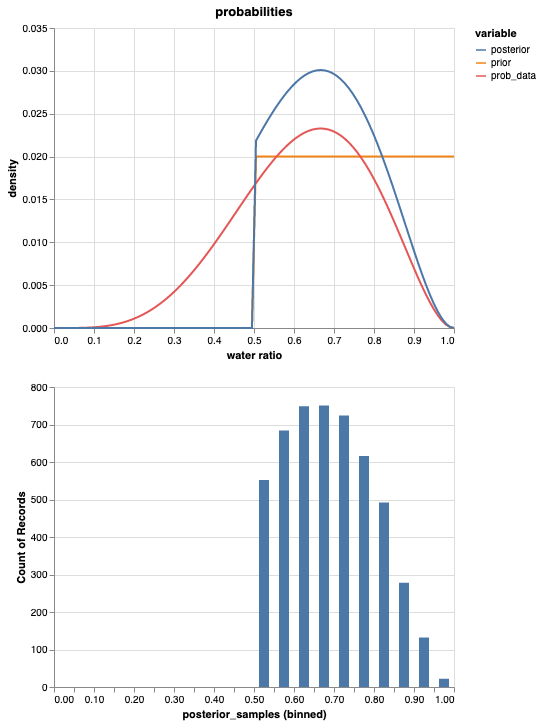

In [8]:
prob_lines = (
    alt.Chart(source, title="probabilities")
    .mark_line()
    .encode(
        alt.X("p_grid", title="water ratio"),
        y="density",
        color="variable",
    )
)

samples_source = pd.DataFrame({"posterior_samples": posterior_samples})
hist = (
    alt.Chart(samples_source)
    .mark_bar(size=10)
    .encode(
        x=alt.X("posterior_samples", bin=alt.BinParams(step=0.05, extent=[0, 1])),
        y="count()",
    )
)

alt.vconcat(prob_lines, hist)

In [9]:
posterior_mean = (p_grid * posterior).mean() * len(p_grid)
posterior_samples_mean = posterior_samples.mean()
print(
    f"posterior_mean={posterior_mean:.4f} posterior_samples_mean={posterior_samples_mean:.4f}"
)

posterior_mean=0.6913 posterior_samples_mean=0.6925


## Exercise 3

For the posterior distribution from 2, compute 89% percentile and HPDI intervals. Compare the widths of these intervals. Which is wider? Why? If you had only the information in the interval, what might you misunderstand about the shape of the posterior distribution?

In [10]:
import statreth as sr

In [11]:
prop_mass = 0.89
hdpi = sr.hdi(posterior_samples, prop_mass)
print(f"HDPI={hdpi} at prop_mass={prop_mass}")
cred_int = sr.pi(posterior_samples, prop_mass)
print(f"PI={cred_int} at prop_mass={prop_mass}")

HDPI=[0.5151515151515152, 0.8484848484848485] at prop_mass=0.89
PI=[0.52525253 0.87878788] at prop_mass=0.89


## Exercise 4

Suppose there is bias in sampling so that Land is more likely than Water to be recorded. Specifically, assume that 1-in-5 (20%) of Water samples are accidentally recorded instead as ”Land”. First, write a generative simulation of this sampling process. Assuming the true proportion of Water is 0.70, what proportion does your simulation tend to produce instead? Second, using a simulated sample of 20 tosses, compute the unbiased posterior distribution of the true proportion of water.

In [12]:
p_error = 0.2
p_water = 0.7

n_measurements = 20  # number of measurments per simulation
n_sim = 1000

In [13]:
# true water samples
true_samples = np.random.binomial(n_measurements, p=p_water, size=n_sim)
# take true samples and reduce them according to p_error
obs_samples = np.random.binomial(true_samples, p=(1 - p_error))

In [14]:
print("true sample mean:", true_samples.mean() / n_measurements)
print("obs sample mean:", obs_samples.mean() / n_measurements)

true sample mean: 0.6974
obs sample mean: 0.5569


In [15]:
# take a biased sample
k = obs_samples[1]
print("number of water samples:", k)

# possible values for uknown parameter: water proportion
p_grid = np.linspace(0, 1, num=100)

prior = stats.beta.pdf(p_grid, 1, 1)
prior = prior / prior.sum()

p_grid_adj = p_grid * (1 - p_error)
prob_data_adj = stats.binom.pmf(k=k, n=n_measurements, p=p_grid_adj)
prob_data_adj = prob_data_adj / prob_data_adj.sum()

posterior_adj = prior * prob_data_adj
posterior_adj = posterior_adj / posterior_adj.sum()

# assume prior is uniform
posterior_biased = stats.binom.pmf(k=k, n=n_measurements, p=p_grid)
posterior_biased = posterior_biased / posterior_biased.sum()

number of water samples: 10


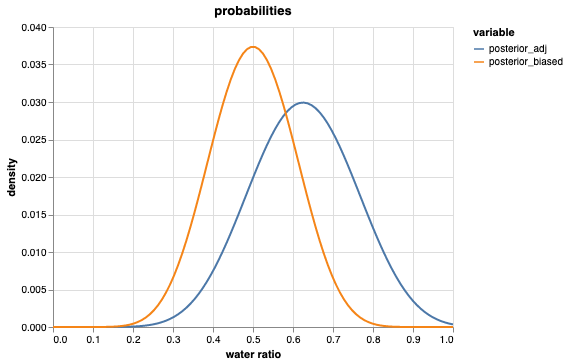

In [16]:
# data source for plotting
source = pd.DataFrame(
    {
        "p_grid": p_grid,
        "posterior_adj": posterior_adj,
        "posterior_biased": posterior_biased,
    }
)

# convert wide df to tall, keep `p_grid` column
source = source.melt("p_grid", value_name="density")

alt.Chart(source, title="probabilities").mark_line().encode(
    alt.X("p_grid", title="water ratio"),
    y="density",
    color="variable",
)